
<div align="center">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/7_Natural_Experiments.ipynb)

</div>






# Natural Experiments

## Causality from Observational Data

Experiments / Random control trials (RCT) are often referred as the gold standards for causality. We can easily establish the important independence assumption by randomizing treatments in experiments:

\begin{equation}
S \perp U
\end{equation}

However, this is not always possible, and experiments are expensive.

How do we learn **causal** insights from large amount of data that we've already observed and collected? e.g.,
- Electronic health records
- Financial market performance
- Biological sequences
- Reddit/Twitter posts

We did not and cannot go back in time to manipulate these data-generating processes to enforce the independence assumption, but there are still methods to infer causal effects from observational data, broadly in the following two ways:
1. Treatment was as-if randomly assigned (maybe for a subset of the population) - Natural Experiments
2. Adjust the treatment and control group characteristics so that they look similar - e.g., through controlling confounders



## 1. Natural Experiments

Sometimes, natural processes give us a treatment that behaves "as-if" random. This allows us to establish the experimental assumption:

\begin{equation}
S \perp U
\end{equation}

We would still need SUTVA and perfect compliance (compliance with the natural process of assigning treatment). Then, everything else follows from the process of estimating effects from experiments.

The challenge here is to identify what dataset and what causal question constitutes a natural experiment.
- In class, we see that we can ask how winning lotteries affects spending.
- Similarly, other examples include asking how military service will affect lifetime earnings (given that it is through draft lottery).
- More?

### Random v.s. Non-random Assignment

First, we can see what random assignment v.s. non-random assignment looks like through the following example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# simulating random treatment assignment
np.random.seed(201)
N = 500
treatment = np.random.binomial(1, 0.5, N)
data_random = pd.DataFrame({
    'treatment': treatment,
    'outcome': np.random.normal(0, 1, N) + 2 * treatment
})

# non-random treatment assignment based on a confounder
confounder = np.random.normal(0, 1, N)
treatment = (confounder > 0).astype(int) # treatment based on signs of U
data_non_random = pd.DataFrame({
    'confounder': confounder,
    'treatment': treatment,
    'outcome': confounder + 2 * treatment + np.random.normal(0, 1, N)
})


print("Random assignment")
print(data_random.head(10))
print("Non-random assignment")
print(data_non_random.head(10))

Random assignment
   treatment   outcome
0          0  0.208307
1          1  1.365955
2          1  0.343714
3          1  0.916081
4          1  0.350137
5          0  0.383980
6          0  0.292093
7          0  1.160619
8          0 -0.296647
9          0 -0.679880
Non-random assignment
   confounder  treatment   outcome
0   -0.125056          0 -1.547934
1    1.496612          1  3.965643
2    0.220468          1  2.315961
3    0.011191          1  1.991408
4   -0.378124          0  0.156474
5   -2.436663          0 -2.242509
6    0.223760          1  2.870007
7   -0.553656          0  1.051514
8    0.048394          1  1.850523
9    0.226738          1  3.058482


Will the second example pass the balance test?

\begin{equation}
p(U|S=1) = p(U|S=0)
\end{equation}

treatment
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: confounder, dtype: object

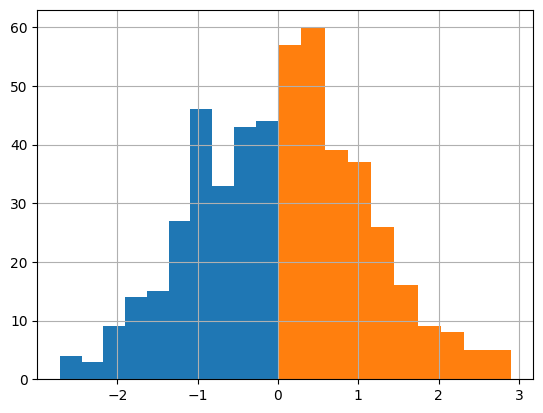

In [2]:
# distributions of confounder given treatment
data_non_random.groupby('treatment')['confounder'].hist()

In [3]:
print(data_non_random.groupby('treatment')['confounder'].mean())

treatment
0   -0.856284
1    0.829128
Name: confounder, dtype: float64


### Case Study: Dutch Postcode Lottery

A famous natural experiment is the Dutch Postcode Lottery. In this lottery, neighborhoods (postal codes) are chosen at random, and everyone in the chosen postal code wins some amount of money.

This creates an "as-if" random treatment group (winners) and a control group (non-winners), allowing us to estimate the causal effect of winning the lottery on spending behavior.

Take-home Exercise: Download the real data file `FinalAnon.dta` from https://www.aeaweb.org/articles?id=10.1257/aer.101.5.2226, and run the following code sample from class. Recreate the balance test!

In [4]:
import pandas as pd
import statsmodels.formula.api as sm

lotto = pd.read_stata('FinalAnon.dta')
lotto

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
dur_est=sm.ols(formula='durable_spending~win_code',
data=lotto).fit(cov_type = 'cluster',
cov_kwds={'groups': lotto['pstk']})
dur_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       durable_spending   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4357
Date:                Thu, 17 Oct 2024   Prob (F-statistic):              0.510
Time:                        13:12:39   Log-Likelihood:                -18342.
No. Observations:                1879   AIC:                         3.669e+04
Df Residuals:                    1877   BIC:                         3.670e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    768.2129    138.482      5.547      0.000     496.792    1039.633
win_code     119.0228    180.316      0.660      0.509    -234.390     472.436
==============================================================================
Omnibus:                     4215.181   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28242902.362
Skew:                          20.149   Prob(JB):                         0.00
Kurtosis:                     602.263   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

Since you will need to agree to the data terms for using the real dataset, we will replicate a simplified version of it here through simulated data.

In [4]:
# simulating the Dutch Postcode Lottery example
np.random.seed(201)
N = 1000

postcode = np.random.randint(1, 50, N)
# select 10 random postcodes to be past winners
winners = np.random.choice(postcode, 10, replace=False)
lottery = np.isin(postcode, winners).astype(int)
data = pd.DataFrame({
    'postcode': postcode,
    'lottery': lottery,
    'spending': np.abs(np.random.normal(1000, 500, N))
})

# lottery winners spend more - causal effect
data.loc[data['lottery'] == 1, 'spending'] += 600

data

,postcode,lottery,spending
0,1,0,390.602612
1,42,0,121.182831
2,1,0,564.648987
3,34,0,1497.473539
4,37,0,313.040010
...,...,...,...
995,34,0,486.917288
996,2,0,1179.313425
997,13,0,1613.079625
998,28,0,331.047279


Now, we have learned two methods for estimating the effects after identifying the causal parameters.

In [5]:
# ATE through conditional expectations
ATE_spending = data[data['lottery'] == 1]['spending'].mean() - data[data['lottery'] == 0]['spending'].mean()
print(f"ATE through conditional expectations: {ATE_spending}")

ATE through conditional expectations: 626.7861219199798


In [6]:
# regress spending on winning
import statsmodels.formula.api as sm
model = sm.ols(formula='spending ~ lottery', data=data)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spending   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     276.1
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           6.45e-55
Time:                        22:35:13   Log-Likelihood:                -7591.4
No. Observations:                1000   AIC:                         1.519e+04
Df Residuals:                     998   BIC:                         1.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1022.4238     16.997     60.154      0.000     989.070    1055.777
lottery      626.7861     37.724     16.615      0.000     552.759     700.814
==============================================================================
Omnibus:                        9.492   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.379
Skew:                           0.213   Prob(JB):                      0.00919
Kurtosis:                       2.790   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# with clustered error
model = sm.ols(formula='spending ~ lottery', data=data)
results = model.fit(cov_type='cluster', cov_kwds={'groups': data['postcode']})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spending   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     433.5
Date:                Thu, 17 Oct 2024   Prob (F-statistic):           1.12e-25
Time:                        22:35:17   Log-Likelihood:                -7591.4
No. Observations:                1000   AIC:                         1.519e+04
Df Residuals:                     998   BIC:                         1.520e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1022.4238     15.953     64.092      0.000     991.157    1053.690
lottery      626.7861     30.105     20.820      0.000     567.782     685.790
==============================================================================
Omnibus:                        9.492   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.379
Skew:                           0.213   Prob(JB):                      0.00919
Kurtosis:                       2.790   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

We would need to provide evidence for the independence assumptions for the observed characteristics. For the real dataset, this includes demographics, family income... Note: this would only apply to the population who participated in the lottery regularly. If we extend it to the general population, we could see, e.g., very different demographics between these who partipate in lotteries and those who don't.

However, this does not eliminate unobserved confounding.

## Control Variables (Preview) and Review

PSA: control variables will not be on the midterm, and we will cover more on it after the midterm.

If the data-generating processes were not naturally randomizing treatment, we can seek to adjust the population in the treatment and control groups.

One adjustment method is through controlling or conditioning on other factors $C$ such that

\begin{equation}
S \perp U \ | \ C
\end{equation}

In this case, we can say that $S$ and $U$ are **conditionally independent** given $C$.

### 2.1 Independence Recap

Independence plays a central role in our arguments for the identification of causal parameters.

$$
P(X \in A, Y \in B) = P(X \in A)P(Y \in B)
$$

Also,

$$
P(Y|X) = P(Y) \ \ \text{and} \ \ P(X|Y) = P(X)
$$

If two variables are independent, then knowing the value of one variable does not provide additional information about the other.

Also, independent variables have a covariance of 0 and are, therefore, uncorrelated.
- Proof in lecture slides by showing $E[XY]=E[X]E[Y]$

We've seen that independence implies 0 covariance and uncorrelatedness.

However, the converse statement is false. Independence is not necessary for uncorrelatedness.

### 2.2 Conditional Independence

$$
P(X \in A, Y \in B | Z) = P(X \in A|Z)P(Y \in B|Z)
$$

Also,

$$
P(Y|X, Z) = P(Y|Z) \ \ \text{and} \ \ P(X|Y, Z) = P(X | Z)
$$

$X$ and $Y$ have no relationship if we account for the value taken by some other variable $Z$. For example, knowing $X$, if we already know $Z$, this does not influence our estimate of $Y$.

In [8]:
# simulate independent random variables
np.random.seed(201)
X_ind = np.random.randint(1, 7, 1000)  # Roll of die 1
Y_ind = np.random.randint(1, 7, 1000)  # Roll of die 2

# calculate covariance of independent variables
cov_ind = np.cov(X_ind, Y_ind)[0, 1]
print(f"Covariance of independent variables: {cov_ind}")

# simulate dependent variables
X_dep = np.random.randint(1, 10, 1000)
Y_dep = 2 * X_dep + np.random.normal(0, 1, 1000)
Z_dep = 2 * X_dep + np.random.normal(0, 1, 1000)

# calculate covariance of dependent variables
cov_dep = np.cov(Y_dep, Z_dep)[0, 1]
print(f"Covariance of dependent variables Y and Z: {cov_dep}")

# calculate covariance of dependent variables condition on X
for X_value in range(1, 10):
  cov_dep = np.cov(Y_dep[X_dep==X_value], Z_dep[X_dep==X_value])[0, 1]
  print(f"Covariance of dependent variables Y and Z condition on X = {X_value}: {cov_dep}")

Covariance of independent variables: -0.09712712712712727
Covariance of dependent variables Y and Z: 25.55082953533942
Covariance of dependent variables Y and Z condition on X = 1: -0.16950780028113066
Covariance of dependent variables Y and Z condition on X = 2: -0.2008651282600672
Covariance of dependent variables Y and Z condition on X = 3: -0.039116306498144265
Covariance of dependent variables Y and Z condition on X = 4: 0.12289574759251388
Covariance of dependent variables Y and Z condition on X = 5: -0.021864156396484553
Covariance of dependent variables Y and Z condition on X = 6: -0.022540072239564873
Covariance of dependent variables Y and Z condition on X = 7: -0.051055281115317146
Covariance of dependent variables Y and Z condition on X = 8: -0.1343325234297629
Covariance of dependent variables Y and Z condition on X = 9: -0.09652086587770842


Graphically, what does conditional independence look like?

![Indep](https://www.researchgate.net/publication/306006513/figure/fig1/AS:393236871958528@1470766384078/Cases-for-d-connectivity-and-d-separation-Black-gray-circles-mean-that-evidence-is.png)

For more intuitive examples, feel free to check out https://www.andrew.cmu.edu/user/scheines/tutor/d-sep.html

### Revisiting -  Revisiting All Causes Model

We have actually covered control variables in Lab 3 if you remember.

Let's review some old concepts and revisit the example again with our new knowledge on regression and experiments.

#### Definition

All causes model:

$$Y(S, U)$$

where $Y$ is the outcome, $S$ is the state of the world, and $U$ is other factors we observe that influence $Y$.

Also, for simplicity, consider $S$ as a binary treatment variable (0 or 1).

Causal quantities of interest:

$$
\begin{align}
\text{ATE} &= E[Y(S=1, U) - Y(S=0, U)]\\
\text{ATT} &= E[Y(S=1, U) - Y(S=0, U)|S=1]\\
\text{ATU} &= E[Y(S=1, U) - Y(S=0, U)|S=0]
\end{align}
$$

**Fundamental problem of causal inference**: we only get to see one of $Y(S=1, U)$ and $Y(S=0, U)$.

Identification is the process where we reduce these equations involving unobserved variables to observed data.

#### 2.3.2 Simulation

Using the old example, we will show how computing only association based on observational data does not give us the true underlying causal effect, and how *control variables* can help us identify these parameters.

- $Y$ is continuous income.
- $S$ is binary college status. (1 = went to college)
- $U$ is binary family status. (1 = wealthy family)

We can see that the true causal effect from college status to income of people will be confounded by the third variable on family status as it is a common cause of both the treatment and outcome, i.e., a wealthy family leads to higher income and more likely to go to college.

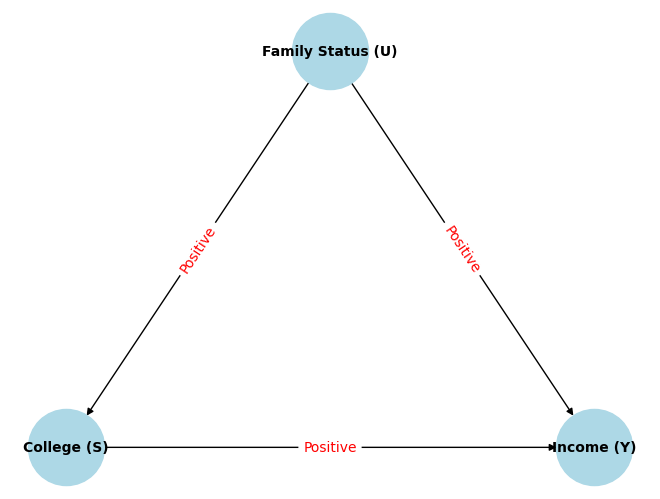

In [9]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Family Status (U)")
G.add_node("College (S)")
G.add_node("Income (Y)")

# Add directed edges representing causal relationships
G.add_edge("Family Status (U)", "College (S)")
G.add_edge("Family Status (U)", "Income (Y)")
G.add_edge("College (S)", "Income (Y)")

# Draw the graph
pos = {
    "Family Status (U)": (0, 1),
    "College (S)": (-1, 0),
    "Income (Y)": (1, 0),
}

labels = {
    ("Family Status (U)", "College (S)"): "Positive",
    ("Family Status (U)", "Income (Y)"): "Positive",
    ("College (S)", "Income (Y)"): "Positive",
}

nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color="red")
plt.show()

Now, let's generate some sythetic data corresponding to this data generative process.

In [10]:
# Step 1: Simulate family status (rich=1, poor=0)
np.random.seed(42)
n = 1000
family_status = np.random.binomial(1, 0.4, n)  # 40% rich, 60% poor

# Step 2: Simulate college attendance based on family status (rich more likely to attend college)
college = np.random.binomial(1, 0.7 * family_status + 0.3 * (1 - family_status), n)

# Step 3: Simulate income based on family status and college attendance

noise = np.random.normal(0, 5000, n)  # Noise to add to income
income_observe = (50000 + 30000 * college + 20000 * family_status + noise)
income_college = (50000 + 30000 * 1 + 20000 * family_status + noise)

# For people who went to college (treated group), compared to the untreated,
# they would have higher income in the counterfactual world where they did not go to college
income_no_college = (50000 + 30000 * 0 + 10000 * college + 20000 * family_status + noise)

# Create a DataFrame for clarity
df = pd.DataFrame({
    'Family_Status': family_status,  # 1 = rich, 0 = poor
    'College': college,  # 1 = went to college, 0 = did not go to college
    'Income_Observe': income_observe,
    'Income_College': income_college,
    'Income_No_College': income_no_college
})

We can calculate the true ATE, ATT, and ATU based on the perfect knowledge we have on the observed and conuterfactual outcomes.

In [11]:
# Step 4: Compute ATE, ATT, ATU
# TRUE ATE:
ATE = df['Income_College'].mean() - df['Income_No_College'].mean()

# ATT:
ATT = df[(df['College'] == 1)]['Income_College'].mean() - df[(df['College'] == 1)]['Income_No_College'].mean()

# ATU:
ATU = df[(df['College'] == 0)]['Income_College'].mean() - df[(df['College'] == 0)]['Income_No_College'].mean()

# Print the results
print(f"TRUE Average Treatment Effect (ATE): {ATE:.2f}")
print(f"TRUE Average Treatment Effect on the Treated (ATT): {ATT:.2f}")
print(f"TRUE Average Treatment Effect on the Untreated (ATU): {ATU:.2f}")

TRUE Average Treatment Effect (ATE): 25560.00
TRUE Average Treatment Effect on the Treated (ATT): 20000.00
TRUE Average Treatment Effect on the Untreated (ATU): 30000.00


What happens if we only have access to the observed treatment and outcome with hidden confounding?

In [12]:
# Step 5: Compute association by conditioning
# Biased ATE using only what was obserevd:
Association = df[df['College'] == 1]['Income_Observe'].mean() - df[df['College'] == 0]['Income_Observe'].mean()

# Print the results
print(f"Biased Average Treatment Effect (ATE): {Association:.2f}")

Biased Average Treatment Effect (ATE): 37639.89


If we have access to potential confounders, we can condition them. Conditional independence helps us here to establish the assumption.

In [13]:
# Step 6: Condition on confounder - family status

Association = df[(df['College'] == 1) & (df['Family_Status'] == 1)]['Income_Observe'].mean() - df[(df['College'] == 0) & (df['Family_Status'] == 1)]['Income_Observe'].mean()

# Print the results
print(f"Association for those with family_status = 1: {Association:.2f}")

Association = df[(df['College'] == 1) & (df['Family_Status'] == 0)]['Income_Observe'].mean() - df[(df['College'] == 0) & (df['Family_Status'] == 0)]['Income_Observe'].mean()

# Print the results
print(f"Association for those with family_status = 0: {Association:.2f}")

Association for those with family_status = 1: 30553.75
Association for those with family_status = 0: 30308.08


Without adding the confounder to our regression setup, the result is biased similar to the conditional expectation without conditioning on the confounder.

In [14]:
import statsmodels.formula.api as sm

ols=sm.ols(formula='Income_Observe~College', data=df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Income_Observe   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     3357.
Date:                Thu, 17 Oct 2024   Prob (F-statistic):          1.55e-321
Time:                        22:37:09   Log-Likelihood:                -10649.
No. Observations:                1000   AIC:                         2.130e+04
Df Residuals:                     998   BIC:                         2.131e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.441e+04    432.902    125.692      0.000    5.36e+04    5.53e+04
College     3.764e+04    649.679     57.936      0.000    3.64e+04    3.89e+04
==============================================================================
Omnibus:                       72.502   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.972
Skew:                           0.209   Prob(JB):                     1.88e-07
Kurtosis:                       2.246   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can only identify it by adding the confounder to establish conditional independence.

In [15]:
ols=sm.ols(formula='Income_Observe~College+Family_Status', data=df).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Income_Observe   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     8981.
Date:                Thu, 17 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:37:15   Log-Likelihood:                -9912.8
No. Observations:                1000   AIC:                         1.983e+04
Df Residuals:                     997   BIC:                         1.985e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.996e+04    221.278    225.780      0.000    4.95e+04    5.04e+04
College        3.041e+04    335.519     90.623      0.000    2.97e+04    3.11e+04
Family_Status   1.98e+04    342.263     57.864      0.000    1.91e+04    2.05e+04
==============================================================================
Omnibus:                        1.170   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                1.054
Skew:                           0.025   Prob(JB):                        0.590
Kurtosis:                       3.151   Cond. No.                         3.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Other Topics for Midterm



*   (Conditional/Joint) Distribution
*   Expectation
*   Variance
*   LIE
*   WLLN
*   CLT
*   hypothesis testing
*   p-value
*   confidence interval
*   experiment
*   (descriptive/causal) (simple/multiple) linear regression

How are these things related to causality (e.g., identification and estimation)? What assumptions did we make?

For instance, LIE was used frequently in some of the derivations on identifiability for causal (multiple) linear regression.

\begin{align*}
E[V] &= E[U - E[U | S, C]] \\
     &= E[U] - E[E[U | S, C]] \\
     &= E[U] - E[U] \quad (\text{LIE})\\
     &= 0
\end{align*}

and

\begin{align*}
E[VS] &= E\left[(U - E[U | S, C]) S \right] \\
      &= E[US - E[U | S, C] S] \\
      &= E[US] - E[E[US | S, C]] \\
      &= E[US] - E[US] \quad (\text{LIE}) \\
      &= 0
\end{align*}

Review session on Monday.

## Good luck on your midterm next week!